In [15]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
sns.set_style('darkgrid')
sns.set(rc={
'axes.facecolor': '#FFF9ED', 
'figure.facecolor': '#FFF9ED'
})
# %config InlineBackend.figure_format = 'retina'

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'


from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as functions
from pyspark.sql.functions import udf, col
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator


In [16]:
spark = SparkSession.builder.master('local[2]')\
    .appName('Linear-Regression-California-Housing')\
    .getOrCreate()

In [17]:
spark

In [18]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Linear-Regression-California-Housing>

In [19]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

# Load the data

In [20]:
schema = StructType([
    StructField('long', FloatType(), nullable=True),
    StructField('1at', FloatType(), nullable=True),
    StructField('medage', FloatType(), nullable=True),
    StructField('totrooms', FloatType(), nullable=True),
    StructField('totbdrms', FloatType(), nullable=True),
    StructField('pop', FloatType(), nullable=True),
    StructField('househlds', FloatType(), nullable=True),
    StructField('medinc', FloatType(), nullable=True),
    StructField('medhv', FloatType(), nullable=True)
])

# load
df = spark.read.format('csv')\
                .schema(schema= schema)\
                .load('cal_housing.data')\
                .cache()

22/08/18 17:09:27 WARN CacheManager: Asked to cache already cached data.


In [21]:
df.take(5)

[Row(long=-122.2300033569336, 1at=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, househlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, 1at=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, househlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, 1at=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, househlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, 1at=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, househlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, 1at=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, househlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [22]:
# show the first 5 rows
df.show(5)

+-------+-----+------+--------+--------+------+---------+------+--------+
|   long|  1at|medage|totrooms|totbdrms|   pop|househlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+---------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|    126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|   1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|    177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|    219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|    259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+---------+------+--------+
only showing top 5 rows



In [23]:
# Show the dataframe schema
df.printSchema()

root
 |-- long: float (nullable = true)
 |-- 1at: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- househlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



# Data Exploration

In [24]:
df.select('pop', 'totbdrms').show(5)

+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
+------+--------+
only showing top 5 rows



## Distribution of the median age of the people

In [25]:
res = df.groupBy('medage')\
        .count()\
        .sort('medage', ascending=False)
res.show(5)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
+------+-----+
only showing top 5 rows



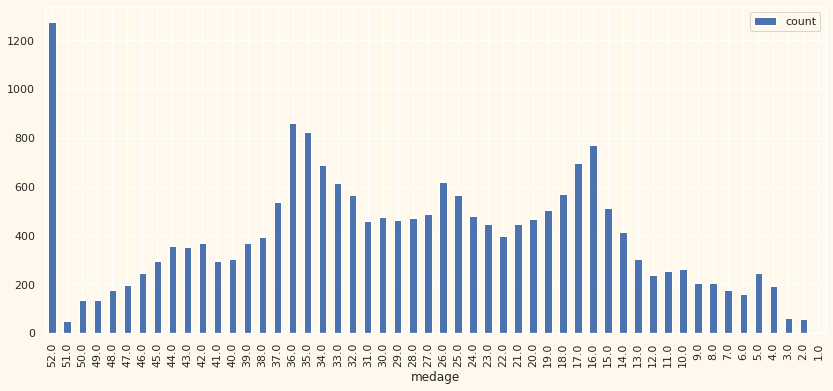

In [29]:
res.toPandas().plot.bar(
    x = 'medage',
    figsize = (14,6)
)
plt.show()

In [34]:
df.describe().select(
    'summary',
    functions.round('medage', 4).alias('medage'),
    functions.round('totrooms', 4).alias('totrooms'),
    functions.round('totbdrms', 4).alias('totbdrms'),
    functions.round('pop', 4).alias('pop'),
    functions.round('househlds', 4).alias('medinc'),
    functions.round('medhv', 4).alias('medhv')
).show(5)

+-------+-------+---------+--------+---------+--------+-----------+
|summary| medage| totrooms|totbdrms|      pop|  medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|   500001.0|
+-------+-------+---------+--------+---------+--------+-----------+



# Data Preprocessing


In [35]:
# Adjust medianhousevalue
df = df.withColumn('medhv', col('medhv') / 100000)

df.show(5)

+-------+-----+------+--------+--------+------+---------+------+-----+
|   long|  1at|medage|totrooms|totbdrms|   pop|househlds|medinc|medhv|
+-------+-----+------+--------+--------+------+---------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|    126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|   1138.0|8.3014|3.585|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|    177.0|7.2574|3.521|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|    219.0|5.6431|3.413|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|    259.0|3.8462|3.422|
+-------+-----+------+--------+--------+------+---------+------+-----+
only showing top 5 rows



# Feature Engineering
* Rooms per household which refers to the number of rooms in households per block group
* Population per household, which basically gives an indication of how many people live in households per block group
* Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group

In [36]:
df = df\
    .withColumn('rmsperhh', functions.round(col('totrooms') / col('househlds'), 2))\
    .withColumn('popperhh', functions.round(col('pop') / col('househlds'), 2))\
    .withColumn('bdrmsperrm', functions.round(col('totbdrms') / col('totrooms'), 2))

df.show(5)

+-------+-----+------+--------+--------+------+---------+------+-----+--------+--------+----------+
|   long|  1at|medage|totrooms|totbdrms|   pop|househlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+---------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|    126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|   1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|    177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|    219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|    259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+---------+------+-----+--------+--------+----------+
only showing top 5 rows



In [43]:
# Re-order and select columns
df = df.select("medhv", 
                "totbdrms", 
                "pop", 
                "househlds", 
                "medinc", 
                "rmsperhh", 
                "popperhh", 
                "bdrmsperrm")

featureCols = ["totbdrms", "pop", "househlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]

We will use vector assembler that combines a given list of columns into a single vector column

In [44]:
assembler = VectorAssembler(
    inputCols= featureCols,
    outputCol= 'features'
)

assembled_df = assembler.transform(df)
assembled_df.show(10, truncate=False)

+-----+--------+------+---------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |househlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+---------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0    |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0   |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0    |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0    |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0    |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0

In [46]:
# Standardization
scaler = StandardScaler(
    inputCol='features',
    outputCol= 'features_scaled'
)

scaled_df = scaler.fit(assembled_df).transform(assembled_df)

scaled_df.select('features', 'features_scaled').show(10, truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

# Build a Machine Learning Model with Spark ML


In [47]:
# Split the data into train and test sets
train_df, test_df = scaled_df.randomSplit([.8, .2], seed= 42)

In [51]:
lr = LinearRegression(
    featuresCol= 'features_scaled',
    labelCol='medhv',
    predictionCol= 'predmedhv',
    maxIter=10,
    regParam = 0.3,
    elasticNetParam=0.8,
    standardization=False
)

model = lr.fit(train_df)

## Evaluating the Model
With our model in place, we can generate predictions for our test data: use the transform() method to predict the labels for our test data. Then we can use RDD operations to extract the predictions

In [52]:
model.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5239, 0.0, 0.0, 0.0])

In [53]:
model.intercept

0.9974340553372637

## Generating Predictions

In [54]:
pred = model.transform(test_df)

labels = pred.select('predmedhv', 'medhv')
labels.show(10)

+------------------+-------+
|         predmedhv|  medhv|
+------------------+-------+
| 1.576515000990561|0.14999|
|1.2157475832881173|  0.225|
| 1.745772109971059|  0.225|
| 1.752362611773625|  0.283|
|1.5081007416432501|  0.325|
|1.5891445388808378|  0.344|
|1.4929343496988183|  0.375|
|1.5977755558708089|  0.392|
|1.5650988454600079|  0.409|
|1.3716582423745671|   0.41|
+------------------+-------+
only showing top 10 rows



# Inspect the metrics

In [55]:
print(f"RMSE: {model.summary.rootMeanSquaredError} ")

RMSE: 0.8796093976484325 


In [57]:
print(f"MAE: {model.summary.meanAbsoluteError} ")

MAE: 0.6765198107011212 


## Using the RegressionEvaluator from pyspark

In [58]:
evaluator = RegressionEvaluator(
    predictionCol='predmedhv',
    labelCol='medhv',
    metricName='rmse'
)

print(f"RMSE: {evaluator.evaluate(labels)} ")

RMSE: 0.8807530909856098 


In [59]:
evaluator = RegressionEvaluator(
    predictionCol='predmedhv',
    labelCol='medhv',
    metricName='mae'
)

print(f"MAE: {evaluator.evaluate(labels)} ")

MAE: 0.675259696669788 


In [60]:
spark.stop()